# Face Detection Testing

Dataset: <https://www.kaggle.com/datasets/drgilermo/face-images-with-marked-landmark-points/data>

Pulling the data:

```sh
#!/bin/bash
curl -L -o data/face-images-with-marked-landmark-points.zip \
  https://www.kaggle.com/api/v1/datasets/download/drgilermo/face-images-with-marked-landmark-points
```


In [ ]:
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from dataclasses import dataclass

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
face_images_db = np.load("data/face_images.npz")["face_images"]
facial_keypoints_df = pd.read_csv("data/facial_keypoints.csv")

(im_height, im_width, num_images) = face_images_db.shape
num_keypoints = facial_keypoints_df.shape[1] / 2


/var/folders/y0/vzbknx790l9gxxnhh98_987h0000gn/T/ipykernel_69641/2132504517.py:1: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  face_images_db = np.load("data/face_images.npz")["face_images"]


In [4]:
face_img_col = (
    np.transpose(face_images_db, (2, 0, 1))
    .reshape(num_images, im_height * im_width)
    .astype(np.uint8)
)
face_img_col = [np.array(l, dtype=np.uint8) for l in face_img_col.tolist()]


df = facial_keypoints_df.copy()
df.insert(0, "face_image", face_img_col)
df = df.dropna(axis=0, how="any")

df.head()

,face_image,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,"[238, 236, 237, 238, 240, 240, 239, 241, 241, ...",66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,"[219, 215, 204, 196, 204, 211, 212, 200, 180, ...",64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,"[144, 142, 159, 180, 188, 188, 184, 180, 167, ...",65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,"[193, 192, 193, 194, 194, 194, 193, 192, 168, ...",65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,"[147, 148, 160, 196, 215, 214, 216, 217, 219, ...",66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [5]:
train_df = df.sample(frac=0.8, random_state=RANDOM_SEED)
test_df = df.drop(train_df.index)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"{train_df.shape}")
print(f"{test_df.shape}")


(1712, 31)
(428, 31)


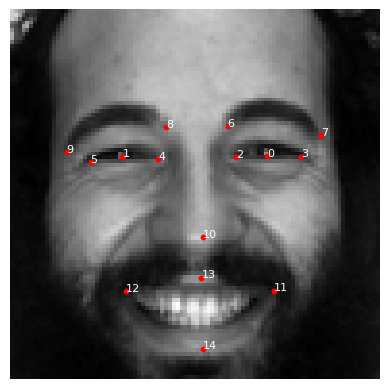

In [43]:
first_img = train_df.iloc[0]["face_image"]
keypoints_x = train_df[[c for c in train_df.columns if c.endswith("_x")]].values[0]
keypoints_y = train_df[[c for c in train_df.columns if c.endswith("_y")]].values[0]

plt.figure()
plt.imshow(first_img.reshape(im_height, im_width), cmap="gray")
plt.scatter(keypoints_x, keypoints_y, c="r", s=10)
for i in range(int(num_keypoints)):
    plt.text(keypoints_x[i], keypoints_y[i], str(i), color="white", fontsize=8)
plt.axis("off")
plt.show()

In [7]:
@dataclass
class KeypointSearchResult:
    hottest_point: tuple
    heatmap: np.ndarray

    def distance(self, other):
        return np.sqrt(
            (self.hottest_point[0] - other.hottest_point[0]) ** 2
            + (self.hottest_point[1] - other.hottest_point[1]) ** 2
        )


class KeypointModel:
    _img_width = 96
    _img_height = 96
    _region_size = 6
    _kp_regions = defaultdict(list)
    _kp_regions_edges = defaultdict(list)
    _top_n = 1

    def img_edges(self, img: np.ndarray):
        img_edges = cv2.filter2D(
            img, -1, np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
        )
        return img_edges

    def train(self, train_df: pd.DataFrame):
        self.train_df = train_df.copy()

        kp_names = [s[:-2] for s in train_df.columns if s.endswith("_x")]

        for row in tqdm(train_df.itertuples(), total=len(train_df)):
            img = row.face_image.reshape(self._img_height, self._img_width)
            img_edges = self.img_edges(img)

            kp_x = train_df.loc[row.Index][
                [c for c in train_df.columns if c.endswith("_x")]
            ]
            kp_y = train_df.loc[row.Index][
                [c for c in train_df.columns if c.endswith("_y")]
            ]

            for i in range(len(kp_x)):
                x = int(kp_x.iloc[i])
                y = int(kp_y.iloc[i])
                kp_name = kp_names[i]

                top = y - self._region_size
                left = x - self._region_size
                bottom = y + self._region_size
                right = x + self._region_size

                # Check if the region is within the image bounds
                if (
                    top < 0
                    or left < 0
                    or bottom >= self._img_height
                    or right >= self._img_width
                ):
                    continue

                region = img[top : bottom + 1, left : right + 1]
                region_edges = img_edges[top : bottom + 1, left : right + 1]

                self._kp_regions[kp_name].append(region)
                self._kp_regions_edges[kp_name].append(region_edges)

    def search(self, img: np.ndarray):
        img = img.reshape(self._img_height, self._img_width)
        kp_names = list(self._kp_regions.keys())
        kp_coords = dict()

        def process_kp_name(kp_name):
            regions = self._kp_regions_edges[kp_name]
            points = np.zeros((len(regions) * self._top_n, 2), dtype=int)

            img_edges = self.img_edges(img)

            for i, region in enumerate(regions):
                points_start = i * self._top_n
                points_end = int(
                    np.min([(i + 1) * self._top_n, len(regions) * self._top_n])
                )

                filtered = self._search_filter(img_edges, region)

                top_n = np.unravel_index(
                    np.argsort(filtered, axis=None)[-self._top_n :], filtered.shape
                )
                top_n = np.array(top_n).T + self._region_size

                points[points_start:points_end, :] = top_n

            return kp_name, points

        with ThreadPoolExecutor() as tpe:
            results = list(tpe.map(process_kp_name, kp_names))

        for kp_name, points in results:
            heatmap = np.zeros((self._img_height, self._img_width), dtype=np.uint32)
            for coord in points:
                heatmap[coord[0], coord[1]] += 1

            hottest_point = np.unravel_index(np.argmax(heatmap), heatmap.shape)

            # log_heatmap = np.log(heatmap.astype(np.float32) + 1)

            # # Overlay heatmap on the image
            # plt.figure()
            # plt.imshow(img, cmap="gray", alpha=1.0)  # Display the image in grayscale
            # plt.imshow(log_heatmap, cmap="jet", alpha=0.5)  # Overlay the heatmap
            # plt.scatter(
            #     hottest_point[1], hottest_point[0], c="r", s=100, label="Hottest Point"
            # )
            # plt.title(f"Keypoint: {kp_name}")
            # plt.axis("off")
            # plt.colorbar(label="Heatmap Intensity")
            # plt.show()

            kp_coords[kp_name] = KeypointSearchResult(
                hottest_point=hottest_point,
                heatmap=heatmap,
            )

        return kp_coords

    def _search_filter(self, img: np.ndarray, filter_: np.ndarray):
        filtered = cv2.matchTemplate(img, filter_, cv2.TM_CCOEFF_NORMED)
        return filtered

    def evaluate(self, test_df: pd.DataFrame):
        test_df = test_df.copy()

        columar = defaultdict(list)

        def process_row(row):
            img = row.face_image.reshape(self._img_height, self._img_width)
            search_results = self.search(img)
            return row.Index, search_results

        with ThreadPoolExecutor() as executor:
            results = list(
                tqdm(
                    executor.map(process_row, test_df.itertuples()),
                    total=len(test_df),
                    desc="Evaluating images",
                )
            )

        for _, search_results in results:
            for kp_name, search_result in search_results.items():
                col_x = f"eval_{kp_name}_x"
                col_y = f"eval_{kp_name}_y"

                columar[col_x].append(search_result.hottest_point[1])
                columar[col_y].append(search_result.hottest_point[0])

        return pd.DataFrame(columar, index=test_df.index)

In [8]:
kpm = KeypointModel()
kpm.train(train_df)

100%|██████████| 1712/1712 [00:00<00:00, 4236.43it/s]


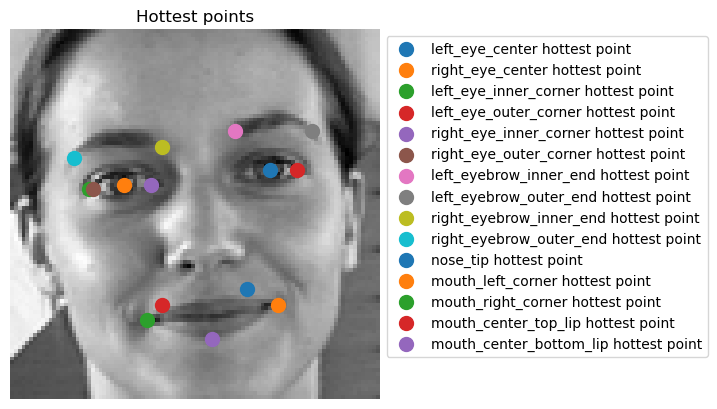

In [9]:
im = test_df.iloc[32]["face_image"].reshape(im_height, im_width)

first_search = kpm.search(im)

plt.figure()
plt.imshow(im.reshape(im_height, im_width), cmap="gray")
for kp_name, search_result in first_search.items():
    plt.scatter(
        search_result.hottest_point[1],
        search_result.hottest_point[0],
        s=100,
        label=f"{kp_name} hottest point",
    )
plt.axis("off")
plt.title("Hottest points")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


In [22]:
tested = kpm.evaluate(test_df)

Evaluating images: 100%|██████████| 428/428 [14:52<00:00,  2.09s/it]


In [23]:
tested.shape

(428, 30)

In [24]:
tested_joined = test_df.join(tested, how="inner")
print(tested_joined.shape)
tested_joined.head()

(428, 61)


,face_image,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,...,eval_nose_tip_x,eval_nose_tip_y,eval_mouth_left_corner_x,eval_mouth_left_corner_y,eval_mouth_right_corner_x,eval_mouth_right_corner_y,eval_mouth_center_top_lip_x,eval_mouth_center_top_lip_y,eval_mouth_center_bottom_lip_x,eval_mouth_center_bottom_lip_y
0,"[219, 215, 204, 196, 204, 211, 212, 200, 180, ...",64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,...,47,55,57,76,33,75,30,20,81,80
1,"[164, 158, 118, 76, 66, 69, 59, 53, 43, 31, 35...",65.802880,34.755200,27.475840,36.185600,58.652160,37.329280,72.952960,35.899520,36.342400,...,11,22,64,73,32,74,29,22,47,83
2,"[201, 200, 202, 193, 124, 59, 53, 50, 48, 56, ...",66.676941,33.941224,30.713647,36.149506,60.367059,35.203129,71.724000,33.310306,36.707294,...,48,57,85,60,54,60,73,22,67,46
3,"[202, 201, 201, 202, 201, 200, 200, 200, 199, ...",66.850428,35.636988,32.528110,36.524623,61.228800,36.524623,71.584883,35.341109,38.149738,...,49,55,56,80,55,72,49,89,49,86
4,"[64, 56, 53, 51, 57, 74, 85, 86, 88, 90, 95, 9...",69.233455,40.021527,25.550836,38.071855,60.262691,40.021527,76.254545,40.411636,33.351273,...,9,51,62,81,28,80,46,79,45,88


In [25]:
kp_names = [
    c[:-2] for c in test_df.columns if c.endswith("_x") and not c.startswith("eval_")
]
actual_col_x = [f"{kp_name}_x" for kp_name in kp_names]
actual_col_y = [f"{kp_name}_y" for kp_name in kp_names]
eval_col_x = [f"eval_{kp_name}_x" for kp_name in kp_names]
eval_col_y = [f"eval_{kp_name}_y" for kp_name in kp_names]

actual_list = []
pred_list = []

# Calculate error
errors_dict = defaultdict(list)
for i in range(len(tested_joined)):
    this_actual = []
    this_pred = []
    for j in range(len(kp_names)):
        actual_x = tested_joined.iloc[i][actual_col_x[j]]
        actual_y = tested_joined.iloc[i][actual_col_y[j]]
        eval_x = tested_joined.iloc[i][eval_col_x[j]]
        eval_y = tested_joined.iloc[i][eval_col_y[j]]

        # error = np.sqrt((actual_x - eval_x) ** 2 + (actual_y - eval_y) ** 2)
        # errors_dict[kp_names[j]].append(error)

        this_actual.append((actual_x, actual_y))
        this_pred.append((eval_x, eval_y))

    actual_list.append(this_actual)
    pred_list.append(this_pred)

actual = np.array(actual_list)
pred = np.array(pred_list)

# (428, 15, 2) -> (428, 15, 2) translate
actual = np.transpose(actual, (0, 2, 1))
pred = np.transpose(pred, (0, 2, 1))

print(actual.shape)
print(pred.shape)

# errors_raw = pd.DataFrame(errors_dict)
# errors_raw.head()

(428, 2, 15)
(428, 2, 15)


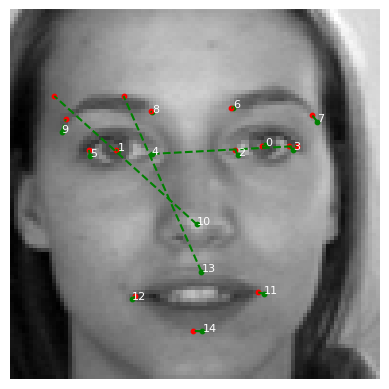

In [67]:
test_index = 1

first_test_img = test_df.iloc[test_index]["face_image"].reshape(im_height, im_width)
actual_kps = actual[test_index]
pred_kps = pred[test_index]

plt.figure()
plt.imshow(first_test_img, cmap="gray")
for i in range(actual_kps.shape[1]):
    plt.scatter(actual_kps[0][i], actual_kps[1][i], c="green", s=10)
    plt.text(actual_kps[0][i], actual_kps[1][i], str(i), color="white", fontsize=8)
for i in range(pred_kps.shape[1]):
    plt.scatter(pred_kps[0][i], pred_kps[1][i], c="red", s=10)
# Draw lines between actual and predicted keypoints
for i in range(actual_kps.shape[1]):
    plt.plot(
        [actual_kps[0][i], pred_kps[0][i]],
        [actual_kps[1][i], pred_kps[1][i]],
        c="g",
        linestyle="--",
    )
plt.axis("off")
plt.show()

# Performance Evaluation


In [47]:
# Difference between the predicted and actual keypoints in terms of im width
diff = (pred - actual) / im_width
diff.shape

(428, 2, 15)

## RMSE


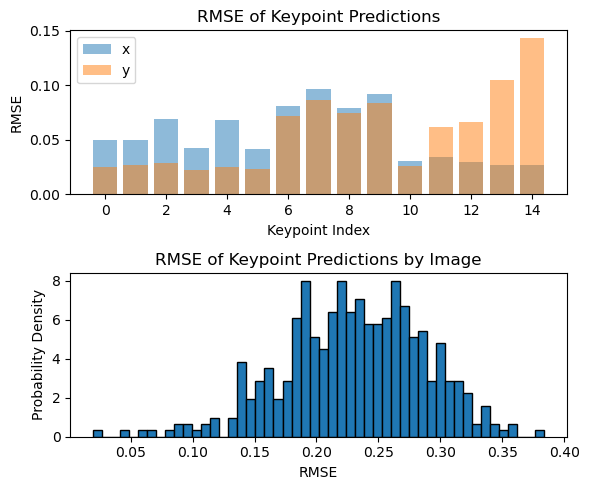

Images with highest error (RMSE): [array([329,  61, 116,  94, 244])]
RMSE values: [0.38396811 0.3602468  0.3556542  0.34869119 0.34619213]

Images with lowest error (RMSE): [array([124, 218, 296, 144, 188])]
RMSE values: [0.01956734 0.04781957 0.06083379 0.06724393 0.08442267]

Correlation between x and y errors: 0.5399


In [57]:
rmse_by_keypoint = np.mean(diff**2, axis=0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))

ax1.bar(range(rmse_by_keypoint.shape[1]), rmse_by_keypoint[0], label="x", alpha=0.5)
ax1.bar(range(rmse_by_keypoint.shape[1]), rmse_by_keypoint[1], label="y", alpha=0.5)
ax1.set_title("RMSE of Keypoint Predictions")
ax1.set_xlabel("Keypoint Index")
ax1.set_ylabel("RMSE")
ax1.legend()

rmse_by_im = np.sqrt(np.mean(diff**2, axis=(1, 2)))

ax2.hist(rmse_by_im, bins=50, edgecolor="black", density=True)
ax2.set_title("RMSE of Keypoint Predictions by Image")
ax2.set_xlabel("RMSE")
ax2.set_ylabel("Probability Density")

plt.tight_layout()
plt.show()

worst_indices = np.argsort(-rmse_by_im)[:5]
best_indices = np.argsort(rmse_by_im)[:5]

print(f"Images with highest error (RMSE): {[worst_indices]}")
print(f"RMSE values: {rmse_by_im[worst_indices]}")
print(f"\nImages with lowest error (RMSE): {[best_indices]}")
print(f"RMSE values: {rmse_by_im[best_indices]}")

x_errors = np.abs(diff[0])
y_errors = np.abs(diff[1])
correlation = np.corrcoef(x_errors.flatten(), y_errors.flatten())[0, 1]
print(f"\nCorrelation between x and y errors: {correlation:.4f}")

## MSE


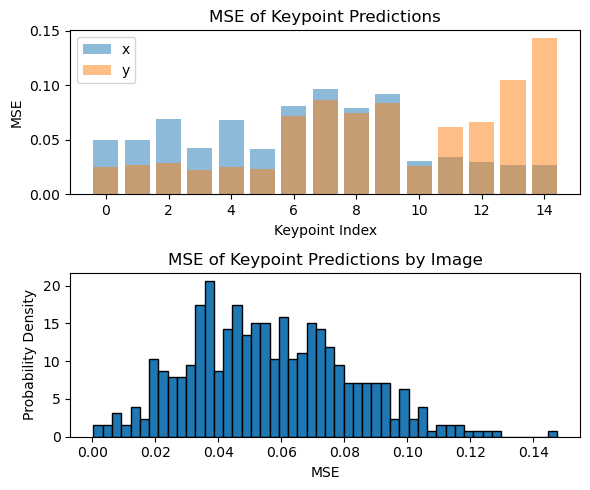

Images with highest error (MSE): [array([329,  61, 116,  94, 244])]
MSE values: [0.14743151 0.12977776 0.12648991 0.12158555 0.11984899]

Images with lowest error (MSE): [array([124, 218, 296, 144, 188])]
MSE values: [0.00038288 0.00228671 0.00370075 0.00452175 0.00712719]

Correlation between x and y errors: 0.5399


In [58]:
mse_by_keypoint = np.mean(diff**2, axis=0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))

ax1.bar(range(mse_by_keypoint.shape[1]), mse_by_keypoint[0], label="x", alpha=0.5)
ax1.bar(range(mse_by_keypoint.shape[1]), mse_by_keypoint[1], label="y", alpha=0.5)
ax1.set_title("MSE of Keypoint Predictions")
ax1.set_xlabel("Keypoint Index")
ax1.set_ylabel("MSE")
ax1.legend()

mse_by_im = np.mean(diff**2, axis=(1, 2))

ax2.hist(mse_by_im, bins=50, edgecolor="black", density=True)
ax2.set_title("MSE of Keypoint Predictions by Image")
ax2.set_xlabel("MSE")
ax2.set_ylabel("Probability Density")

plt.tight_layout()
plt.show()

worst_indices = np.argsort(-mse_by_im)[:5]
best_indices = np.argsort(mse_by_im)[:5]

print(f"Images with highest error (MSE): {[worst_indices]}")
print(f"MSE values: {mse_by_im[worst_indices]}")
print(f"\nImages with lowest error (MSE): {[best_indices]}")
print(f"MSE values: {mse_by_im[best_indices]}")

x_errors = np.abs(diff[0])
y_errors = np.abs(diff[1])
correlation = np.corrcoef(x_errors.flatten(), y_errors.flatten())[0, 1]
print(f"\nCorrelation between x and y errors: {correlation:.4f}")